In [2]:
# Importing the useful libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.preprocessing import  OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, recall_score, precision_score, roc_auc_score, ConfusionMatrixDisplay
import xgboost as xgb
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import warnings
from model_trainer import ModelTrainer

In [3]:
# Reading the data files
data_train = pd.read_csv("conversion_data_train.csv")
data_test = pd.read_csv("conversion_data_test.csv")


In [4]:
pd.options.display.max_rows = None # display all rows of dataframes

# Part 1: Exploratory Data Analysis and Data Preprocessing

In [5]:
# in order not to read the file every time we need to reload the data
conversion_data = data_train.copy()

## Displaying basic stats about the dataset:

In [6]:
# Basic stats about the dataframe
print(f"Number of rows : {conversion_data.shape[0]}")
print()

print("Basic info: ")
conversion_data.info()
print()

print("Display of conversion_data: ")
display(conversion_data.head())
print()

print("Basics statistics: ")
data_desc = conversion_data.describe(include='all')
display(data_desc)
print()

print("Percentage of missing values: ")
display(pd.DataFrame(np.round(100*conversion_data.isnull().sum()/conversion_data.shape[0]), columns=['% missing values']))

Number of rows : 284580

Basic info: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284580 entries, 0 to 284579
Data columns (total 6 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   country              284580 non-null  object
 1   age                  284580 non-null  int64 
 2   new_user             284580 non-null  int64 
 3   source               284580 non-null  object
 4   total_pages_visited  284580 non-null  int64 
 5   converted            284580 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 13.0+ MB

Display of conversion_data: 


country  age  new_user  source  total_pages_visited  converted
0    China   22         1  Direct                    2          0
1       UK   21         1     Ads                    3          0
2  Germany   20         0     Seo                   14          1
3       US   23         1     Seo                    3          0
4       US   28         1  Direct                    3          0


Basics statistics: 


country            age       new_user  source  total_pages_visited   
count   284580  284580.000000  284580.000000  284580        284580.000000  \
unique       4            NaN            NaN       3                  NaN   
top         US            NaN            NaN     Seo                  NaN   
freq    160124            NaN            NaN  139477                  NaN   
mean       NaN      30.564203       0.685452     NaN             4.873252   
std        NaN       8.266789       0.464336     NaN             3.341995   
min        NaN      17.000000       0.000000     NaN             1.000000   
25%        NaN      24.000000       0.000000     NaN             2.000000   
50%        NaN      30.000000       1.000000     NaN             4.000000   
75%        NaN      36.000000       1.000000     NaN             7.000000   
max        NaN     123.000000       1.000000     NaN            29.000000   

            converted  
count   284580.000000  
unique            NaN  
top               NaN  
freq              NaN  
mean         0.032258  
std          0.176685  
min          0.000000  
25%          0.000000  
50%          0.000000  
75%          0.000000  
max          1.000000


Percentage of missing values: 


% missing values
country                           0.0
age                               0.0
new_user                          0.0
source                            0.0
total_pages_visited               0.0
converted                         0.0

We have no missing values, so we won't need to worry about imputing values during the preprocessing.

## Visualising our target variable and features:

In [7]:
fig = px.box(data_train, x = 'age')
fig.show()

based on the figure above, we can already already see some outliers for the age.
We would like to get rid of them based on the following rule.

In [8]:
# Dropping age outliers
conversion_data = conversion_data.loc[conversion_data['age'].between(conversion_data['age'].mean() - 3*conversion_data['age'].std(), conversion_data['age'].mean() + 3*conversion_data['age'].std())]

In [9]:
fig = px.box(conversion_data, x = 'age')
fig.show()

In [10]:
# Checking again the basic statistics
conversion_data.describe(include='all')

country            age       new_user  source  total_pages_visited   
count   283563  283563.000000  283563.000000  283563        283563.000000  \
unique       4            NaN            NaN       3                  NaN   
top         US            NaN            NaN     Seo                  NaN   
freq    159528            NaN            NaN  138990                  NaN   
mean       NaN      30.463262       0.685442     NaN             4.873996   
std        NaN       8.104432       0.464340     NaN             3.343592   
min        NaN      17.000000       0.000000     NaN             1.000000   
25%        NaN      24.000000       0.000000     NaN             2.000000   
50%        NaN      30.000000       1.000000     NaN             4.000000   
75%        NaN      36.000000       1.000000     NaN             7.000000   
max        NaN      55.000000       1.000000     NaN            29.000000   

            converted  
count   283563.000000  
unique            NaN  
top               NaN  
freq              NaN  
mean         0.032349  
std          0.176926  
min          0.000000  
25%          0.000000  
50%          0.000000  
75%          0.000000  
max          1.000000

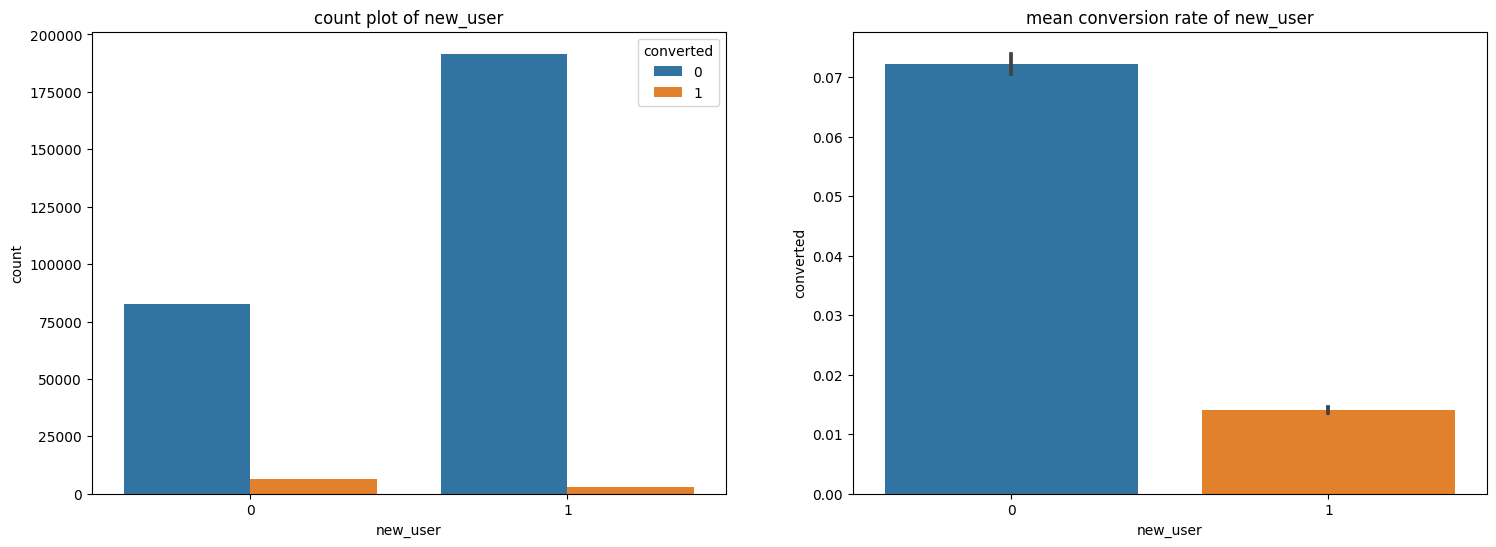

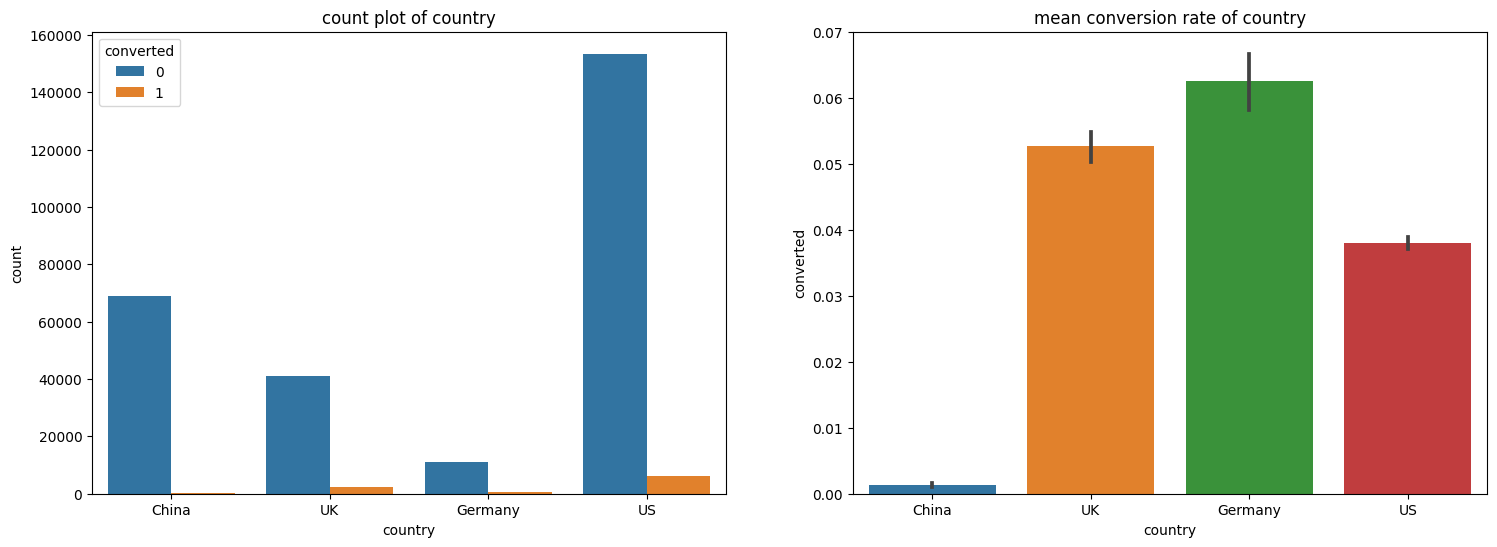

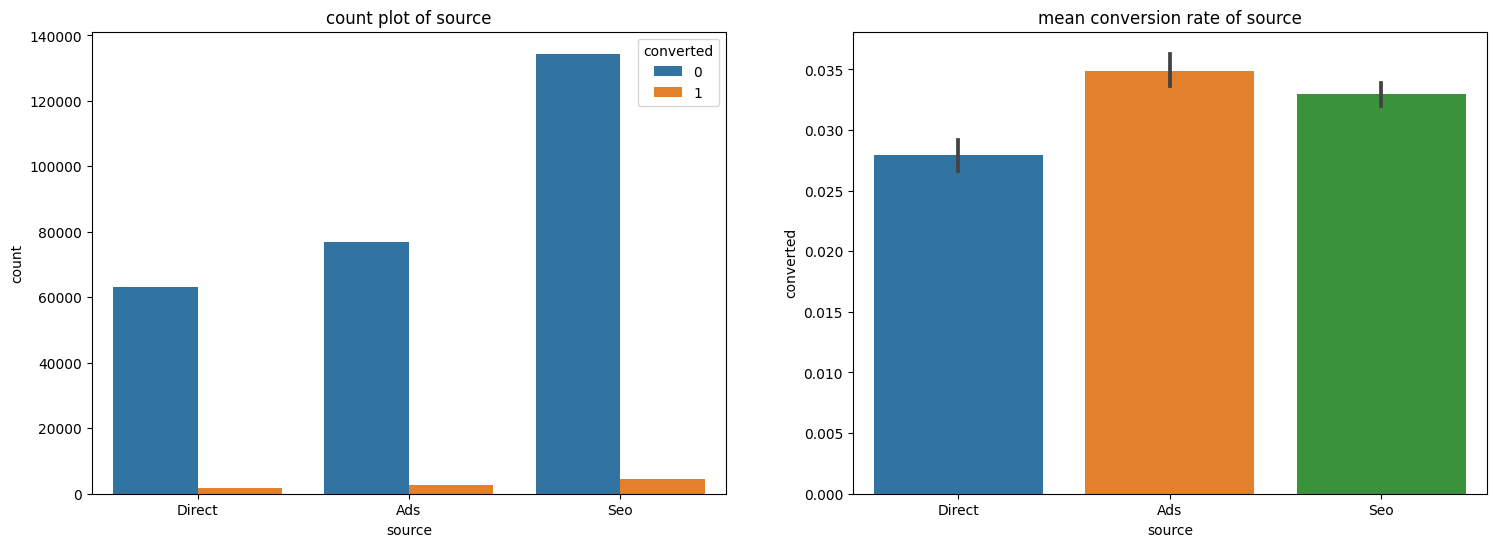

In [11]:
for col in ['new_user','country', 'source']:
    fix, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (18,6))
    sns.countplot( x= col, hue = 'converted', data = conversion_data, ax = ax[0])
    ax[0].set_title('count plot of {}'.format(col))
    sns.barplot(x = col, y= 'converted', data = conversion_data, ax = ax[1])
    ax[1].set_title('mean conversion rate of {}'.format(col))

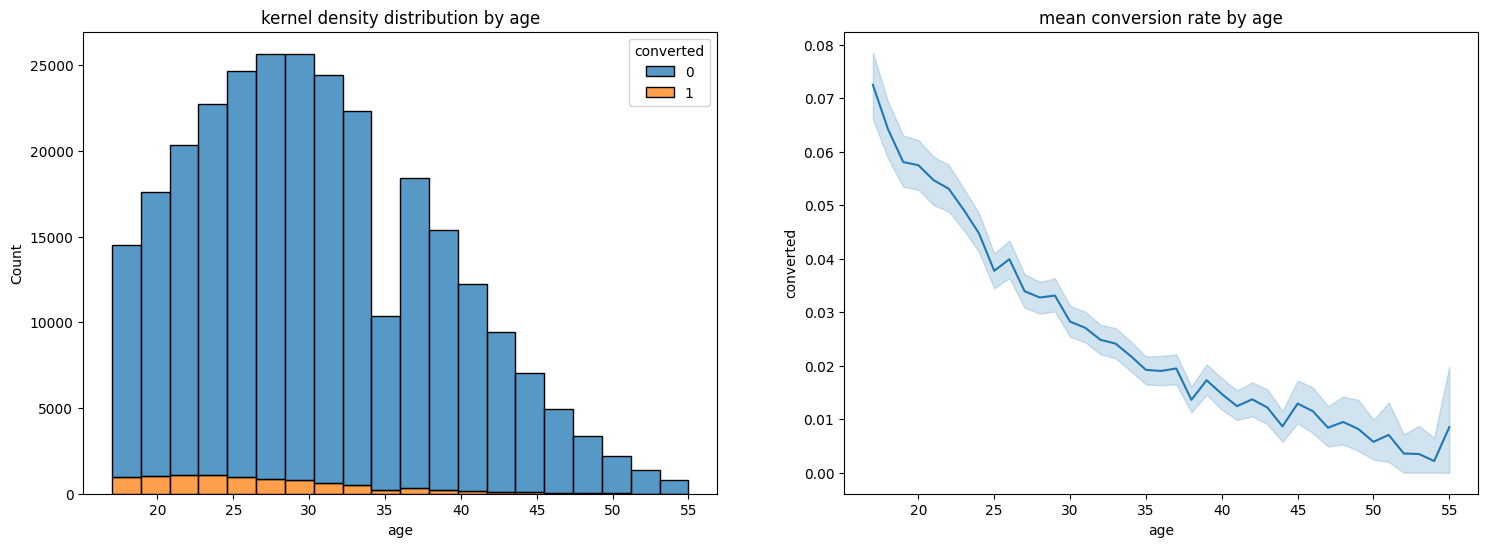

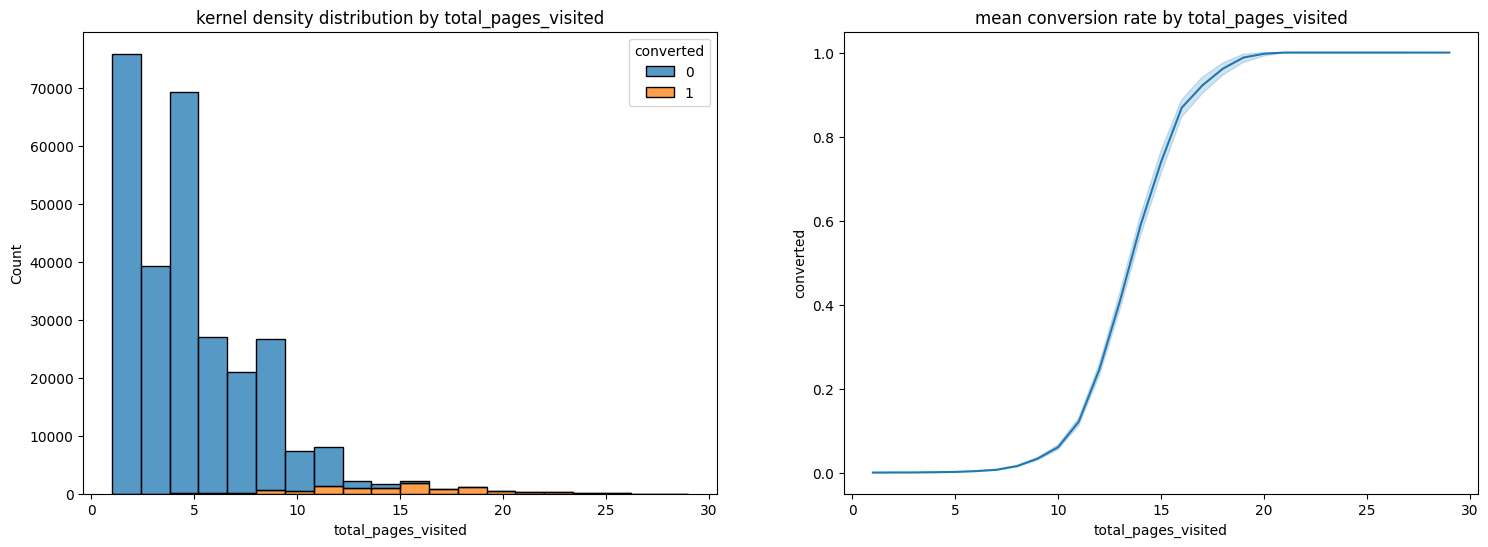

In [12]:

for col in ['age','total_pages_visited']:
    fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (18,6))
    sns.histplot(x=col,data=conversion_data, bins = 20, ax = ax[0], hue='converted', multiple='stack')
    ax[0].set_title('kernel density distribution by {}'.format(col))
    sns.lineplot(data=conversion_data, x=col, y='converted', ax=ax[1])
    ax[1].set_title('mean conversion rate by {}'.format(col))

We can already see a problem with our dataset.
The number of non converted observations is much higher than the converted observations.

## Correlation Matrix:

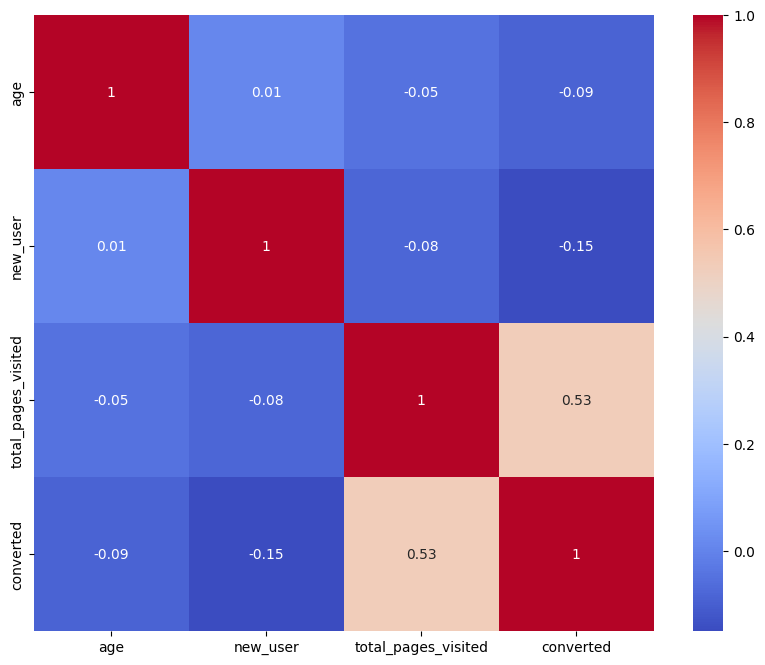

In [13]:
# Visualize correlation matrix
plt.figure(figsize=(10,8))
sns.heatmap(conversion_data.drop(['country', 'source'], axis=1).corr().apply(axis=1, func=lambda x: np.round(x, 2)), annot=True, cmap='coolwarm')
plt.show()

There seems to be a high correlation between total_pages_visited and our target variable.

## Data Preprocessing:

In [14]:
# Separate target variable Y from features X
print("Separating labels from features...")
target_variable = "converted"

X = conversion_data.drop(target_variable, axis = 1)
Y = conversion_data.loc[:,target_variable]

print("...Done.")
print()

print('Y : ')
print(Y.head())
print()
print('X :')
print(X.head())

Separating labels from features...
...Done.

Y : 
0    0
1    0
2    1
3    0
4    0
Name: converted, dtype: int64

X :
   country  age  new_user  source  total_pages_visited
0    China   22         1  Direct                    2
1       UK   21         1     Ads                    3
2  Germany   20         0     Seo                   14
3       US   23         1     Seo                    3
4       US   28         1  Direct                    3


### Separating numerical and categorical features:

In [15]:
# Automatically detect names of numeric/categorical columns
numeric_features = []
categorical_features = []
for i,t in X.dtypes.items():
    if ('float' in str(t)) or ('int' in str(t)) :
        numeric_features.append(i)
    else :
        categorical_features.append(i)

print('Found numeric features ', numeric_features)
print('Found categorical features ', categorical_features)

Found numeric features  ['age', 'new_user', 'total_pages_visited']
Found categorical features  ['country', 'source']


### Splitting our data between train and test sets:

In [16]:
# Divide dataset Train set & Test set 
print("Dividing into train and test sets...")
# WARNING : don't forget stratify=Y for classification problems
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)
print("...Done.")
print()

Dividing into train and test sets...
...Done.



### Building preprocessing pipelines and transforming our data:

In [17]:
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(drop='first')

In [18]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [19]:
# Preprocessings on train set
print("X_train before preprocessing: ")
display(X_train.head())
print("Performing preprocessings on train set...")
X_train = preprocessor.fit_transform(X_train)
print("X_train after preprocessing: ")
display(X_train)
print('preprocessings on train set...Done.')


# Preprocessings on test set
print("X_test before preprocessing: ")
display(X_test.head())
print("Performing preprocessings on test set...")
X_test = preprocessor.transform(X_test) # Don't fit again !
print("X_test after preprocessing: ")
display(X_test)
print('preprocessings on test set...Done.')

X_train before preprocessing: 


country  age  new_user source  total_pages_visited
237253  Germany   27         1    Seo                    6
39533   Germany   27         1    Seo                    3
202077       US   47         0    Seo                    6
181830  Germany   35         0    Seo                   11
263936       US   24         1    Seo                    2

Performing preprocessings on train set...
X_train after preprocessing: 


array([[-0.42970783,  0.6774345 ,  0.33640453, ...,  0.        ,
         0.        ,  1.        ],
       [-0.42970783,  0.6774345 , -0.56056262, ...,  0.        ,
         0.        ,  1.        ],
       [ 2.03722748, -1.47615748,  0.33640453, ...,  1.        ,
         0.        ,  1.        ],
       ...,
       [-1.16978843,  0.6774345 , -1.15854072, ...,  1.        ,
         0.        ,  1.        ],
       [ 0.43371953,  0.6774345 , -0.85955167, ...,  0.        ,
         1.        ,  0.        ],
       [-0.79974813,  0.6774345 ,  0.03741548, ...,  0.        ,
         1.        ,  0.        ]])

preprocessings on train set...Done.
X_test before preprocessing: 


country  age  new_user  source  total_pages_visited
67148       UK   21         0  Direct                    4
188110      US   24         1     Ads                    3
209603      US   29         0     Seo                    8
263713   China   32         0     Ads                    1
17997       US   39         0  Direct                    1

Performing preprocessings on test set...
X_test after preprocessing: 


array([[-1.16978843, -1.47615748, -0.26157357, ...,  0.        ,
         1.        ,  0.        ],
       [-0.79974813,  0.6774345 , -0.56056262, ...,  1.        ,
         0.        ,  0.        ],
       [-0.1830143 , -1.47615748,  0.93438263, ...,  1.        ,
         0.        ,  1.        ],
       ...,
       [-1.53982873, -1.47615748,  0.03741548, ...,  1.        ,
         0.        ,  0.        ],
       [ 0.68041306, -1.47615748,  0.93438263, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.68041306,  0.6774345 , -1.15854072, ...,  0.        ,
         0.        ,  1.        ]])

preprocessings on test set...Done.


# Part 2: Baseline model (Linear Regressor)

## Training the model:

We start by training a baseline logistic regression model.

In [20]:
# Train model
lr_classifier = LogisticRegression()

print("Training model...")
lr_classifier.fit(X_train, Y_train) # Training is always done on train set !!
print("Training done.")
Y_train_pred = lr_classifier.predict(X_train)
Y_test_pred = lr_classifier.predict(X_test)
f1_train = f1_score(Y_train, Y_train_pred)
f1_test = f1_score(Y_test, Y_test_pred)
precision_train = precision_score(Y_train, Y_train_pred)
precision_test = precision_score(Y_test, Y_test_pred)
recall_train = recall_score(Y_train, Y_train_pred)
recall_test = recall_score(Y_test, Y_test_pred)
roc_auc_train = roc_auc_score(Y_train, Y_train_pred)
roc_auc_test = roc_auc_score(Y_test, Y_test_pred)
benchmark = pd.DataFrame({'model':['LogisticRegressor'], 
                        'f1_train':[np.round(f1_train,3)], 
                        'f1_test':[np.round(f1_test,3)], 
                        'precision_train':[np.round(precision_train,3)],
                        'precision_test':[np.round(precision_test,3)],
                        'recall_train':[np.round(recall_train,3)],
                        'recall_test':[np.round(recall_test,3)],
                        'roc_auc_train':[np.round(roc_auc_train,3)],
                        'roc_auc_test':[np.round(roc_auc_test,3)]})
display(benchmark)

Training model...
Training done.


model  f1_train  f1_test  precision_train  precision_test   
0  LogisticRegressor     0.762    0.769            0.855           0.866  \

   recall_train  recall_test  roc_auc_train  roc_auc_test  
0         0.688        0.692          0.842         0.844

In [21]:
# Perform 5-fold cross-validation to evaluate the generalized accuracy score obtained with a Logistic regression model
print("5-fold cross-validation...")
scores = cross_val_score(lr_classifier, X_train, Y_train, cv=5, scoring="f1")
print('The cross-validated f1 score is : ', scores.mean())
print('The standard deviation on the score is : ', scores.std())

5-fold cross-validation...
The cross-validated f1 score is :  0.7613803448500464
The standard deviation on the score is :  0.004804156881943858


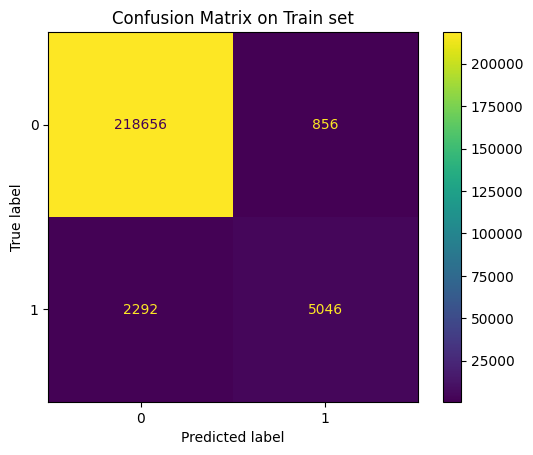

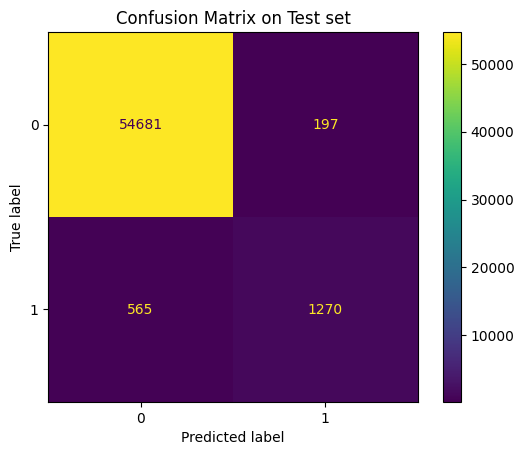

In [22]:
# Visualize confusion matrices
_ , ax = plt.subplots() # Get subplot from matplotlib
ax.set(title="Confusion Matrix on Train set") # Set a title that we will add into ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(lr_classifier, X_train, Y_train, ax=ax) # ConfusionMatrixDisplay from sklearn
plt.show()

_ , ax = plt.subplots() # Get subplot from matplotlib
ax.set(title="Confusion Matrix on Test set") # Set a title that we will add into ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(lr_classifier, X_test, Y_test, ax=ax) # ConfusionMatrixDisplay from sklearn
plt.show()

# Part 3: Rigorous test of models

In order to be as efficient as possible in our model testing, we decide to build a class object that allows us to train multiple models at once.

## Testing and Experimentation:

### Selecting models and metrics:

In [23]:
lr_classifier = LogisticRegression()
rf_classifier = RandomForestClassifier()
dt_classifier = DecisionTreeClassifier()
xgb_classifier = xgb.XGBRFClassifier()

In [24]:
models = [lr_classifier, rf_classifier, dt_classifier, xgb_classifier]
metrics = [f1_score, precision_score, recall_score, roc_auc_score]

In [25]:
param_grid_dt = {
    'max_depth': [5, 7, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': ['balanced', None]
}
param_grid_rf = {
    'max_depth': [5, 7, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': ['balanced', None]
}
param_grid_lr = {
    'C': [0.1, 1, 10],
    'max_iter': [100, 200, 300],
    'solver': ['newton-cholesky', 'lbfgs', 'liblinear'],
    'class_weight': ['balanced', None]
}
param_grid_xgb = { 'max_depth': [4, 6, 8],
                  'min_child_weight': [1, 3, 5],
           'learning_rate': [0.05, 0.1, 0.3],
           'colsample_bytree': [0.7, 1]
}
param_list = [param_grid_rf, param_grid_dt, param_grid_xgb, param_grid_lr, param_grid_xgb]

### Trainer Baseline:

In [26]:
trainer_baseline = ModelTrainer(df= conversion_data,target_variable= 'converted',models= models,metrics= metrics)
trainer_baseline.process()
trainer_baseline.train_evaluate()
trainer_baseline.results

Processing data...
Splitting features and target...
Separating features into numeric and categorical...
Splitting data into train and test sets...
Building preprocessor...
Training LogisticRegression...
Training completed...
Training RandomForestClassifier...
Training completed...
Training DecisionTreeClassifier...
Training completed...
Training XGBRFClassifier...
Training completed...


model experiment  f1_score_train  precision_score_train   
0      LogisticRegression   Baseline        0.762236               0.854964  \
3         XGBRFClassifier   Baseline        0.747361               0.843938   
1  RandomForestClassifier   Baseline        0.804798               0.887738   
2  DecisionTreeClassifier   Baseline        0.799602               0.911262   

   recall_score_train  roc_auc_score_train  f1_score_test   
0            0.687653             0.841877       0.769231  \
3            0.670619             0.833237       0.750610   
1            0.736032             0.866460       0.735426   
2            0.712319             0.855000       0.727217   

   precision_score_test  recall_score_test  roc_auc_score_test  
0              0.865712           0.692098            0.844254  
3              0.851903           0.670845            0.833473  
1              0.814570           0.670300            0.832599  
2              0.825035           0.650136            0.822763

### Trainer with resampling:

In [27]:
trainer_resample = ModelTrainer(conversion_data, 'converted', models, metrics, experiment='resample', resample=True)
trainer_resample.process()
trainer_resample.train_evaluate()
trainer_resample.results

Processing data...
Splitting features and target...
Separating features into numeric and categorical...
Splitting data into train and test sets...
Building preprocessor...
Training LogisticRegression...
Training completed...
Training RandomForestClassifier...
Training completed...
Training DecisionTreeClassifier...
Training completed...
Training XGBRFClassifier...
Training completed...


model experiment  f1_score_train  precision_score_train   
1  RandomForestClassifier   resample        0.982720               0.979527  \
2  DecisionTreeClassifier   resample        0.982709               0.980322   
0      LogisticRegression   resample        0.932094               0.936362   
3         XGBRFClassifier   resample        0.942987               0.936759   

   recall_score_train  roc_auc_score_train  f1_score_test   
1            0.985934             0.985241       0.677488  \
2            0.985107             0.985140       0.673996   
0            0.927865             0.940289       0.552483   
3            0.949298             0.950621       0.543408   

   precision_score_test  recall_score_test  roc_auc_score_test  
1              0.596026           0.784741            0.883478  
2              0.600255           0.768392            0.875641  
0              0.392824           0.930790            0.941342  
3              0.385405           0.920981            0.935936

### Trainer with X features dropped:

#### Trainer with 'age' dropped:

In [28]:
trainer_drop_age = ModelTrainer(conversion_data, 'converted', models, metrics, experiment='drop_age', drop_features=['age'])
trainer_drop_age.process()
trainer_drop_age.train_evaluate()
trainer_drop_age.results

Processing data...
Splitting features and target...
Separating features into numeric and categorical...
Splitting data into train and test sets...
Building preprocessor...
Training LogisticRegression...
Training completed...
Training RandomForestClassifier...
Training completed...
Training DecisionTreeClassifier...
Training completed...
Training XGBRFClassifier...
Training completed...


model experiment  f1_score_train  precision_score_train   
0      LogisticRegression   drop_age        0.750457               0.850777  \
1  RandomForestClassifier   drop_age        0.751070               0.855451   
2  DecisionTreeClassifier   drop_age        0.751070               0.855451   
3         XGBRFClassifier   drop_age        0.743809               0.846850   

   recall_score_train  roc_auc_score_train  f1_score_test   
0            0.671300             0.833682       0.748847  \
1            0.669392             0.832806       0.747226   
2            0.669392             0.832806       0.747226   
3            0.663123             0.829557       0.743156   

   precision_score_test  recall_score_test  roc_auc_score_test  
0              0.858956           0.663760            0.830058  
1              0.860185           0.660490            0.828450  
2              0.860185           0.660490            0.828450  
3              0.853107           0.658311            0.827260

#### Trainer with 'country' dropped:

In [29]:
trainer_drop_country = ModelTrainer(conversion_data, 'converted', models, metrics, experiment='drop_country', drop_features=['country'])
trainer_drop_country.process()
trainer_drop_country.train_evaluate()
trainer_drop_country.results

Processing data...
Splitting features and target...
Separating features into numeric and categorical...
Splitting data into train and test sets...
Building preprocessor...
Training LogisticRegression...
Training completed...
Training RandomForestClassifier...
Training completed...
Training DecisionTreeClassifier...
Training completed...
Training XGBRFClassifier...
Training completed...


model    experiment  f1_score_train   
0      LogisticRegression  drop_country        0.741341  \
3         XGBRFClassifier  drop_country        0.741640   
1  RandomForestClassifier  drop_country        0.761414   
2  DecisionTreeClassifier  drop_country        0.756698   

   precision_score_train  recall_score_train  roc_auc_score_train   
0               0.844452            0.660670             0.828301  \
3               0.850644            0.657400             0.826771   
1               0.856705            0.685200             0.840685   
2               0.872973            0.667757             0.832254   

   f1_score_test  precision_score_test  recall_score_test  roc_auc_score_test  
0       0.747246              0.852059           0.665395            0.830766  
3       0.739439              0.851562           0.653406            0.824799  
1       0.735027              0.825969           0.662125            0.828730  
2       0.722757              0.839827           0.634332            0.815144

#### Trainer with 'source' dropped

In [30]:
trainer_drop_source = ModelTrainer(conversion_data, 'converted', models, metrics, experiment='drop_source', drop_features=['source'])
trainer_drop_source.process()
trainer_drop_source.train_evaluate()
trainer_drop_source.results

Processing data...
Splitting features and target...
Separating features into numeric and categorical...
Splitting data into train and test sets...
Building preprocessor...
Training LogisticRegression...
Training completed...
Training RandomForestClassifier...
Training completed...
Training DecisionTreeClassifier...
Training completed...
Training XGBRFClassifier...
Training completed...


model   experiment  f1_score_train  precision_score_train   
0      LogisticRegression  drop_source        0.761388               0.852415  \
3         XGBRFClassifier  drop_source        0.750494               0.847394   
1  RandomForestClassifier  drop_source        0.780371               0.868258   
2  DecisionTreeClassifier  drop_source        0.777092               0.880718   

   recall_score_train  roc_auc_score_train  f1_score_test   
0            0.687926             0.841972       0.767463  \
3            0.673481             0.834713       0.754809   
1            0.708640             0.852523       0.747451   
2            0.695285             0.846068       0.743153   

   precision_score_test  recall_score_test  roc_auc_score_test  
0              0.862092           0.691553            0.843927  
3              0.858333           0.673569            0.834926  
1              0.831221           0.679019            0.837204  
2              0.841489           0.665395            0.830602

### Trainer with 'source' dropped and resampling:

In [31]:
Y_train_resample_drop_source = ModelTrainer(conversion_data, 'converted', models, metrics, experiment='resample_drop_source', resample=True, drop_features=['source'])
Y_train_resample_drop_source.process()
Y_train_resample_drop_source.train_evaluate()
Y_train_resample_drop_source.results

Processing data...
Splitting features and target...
Separating features into numeric and categorical...
Splitting data into train and test sets...
Building preprocessor...
Training LogisticRegression...
Training completed...
Training RandomForestClassifier...
Training completed...
Training DecisionTreeClassifier...
Training completed...
Training XGBRFClassifier...
Training completed...


model            experiment  f1_score_train   
1  RandomForestClassifier  resample_drop_source        0.968295  \
2  DecisionTreeClassifier  resample_drop_source        0.968281   
0      LogisticRegression  resample_drop_source        0.931129   
3         XGBRFClassifier  resample_drop_source        0.932139   

   precision_score_train  recall_score_train  roc_auc_score_train   
1               0.961640            0.975043             0.972937  \
2               0.962045            0.974599             0.972881   
0               0.935333            0.926962             0.939449   
3               0.929397            0.934897             0.940817   

   f1_score_test  precision_score_test  recall_score_test  roc_auc_score_test  
1       0.621733              0.486171           0.862125            0.915829  
2       0.618850              0.485431           0.853406            0.911579  
0       0.549253              0.389471           0.931335            0.941259  
3       0.522584              0.364359           0.923706            0.934911

### Trainer with feature selection:

In [32]:
conversion_data_new = conversion_data.copy()
conversion_data_new['age_bins'] = pd.cut(conversion_data_new['age'], bins=[0, 20, 30, 40, 50, 60, 100], labels=False)
conversion_data_new['visited_bins'] = pd.cut(conversion_data_new['total_pages_visited'], bins=[0, 5, 10, 15, 20, 30], labels=False)
trainer_feature_selection = ModelTrainer(conversion_data_new, 'converted', models, metrics, experiment='feature_selection', feature_selection=True)
trainer_feature_selection.process()
trainer_feature_selection.train_evaluate()
trainer_feature_selection.results

Processing data...
Splitting features and target...
Separating features into numeric and categorical...
Splitting data into train and test sets...
Building preprocessor...
Training LogisticRegression...
Training completed...
Training RandomForestClassifier...
Training completed...
Training DecisionTreeClassifier...
Training completed...
Training XGBRFClassifier...
Training completed...


model         experiment  f1_score_train   
0      LogisticRegression  feature_selection        0.742469  \
3         XGBRFClassifier  feature_selection        0.742010   
1  RandomForestClassifier  feature_selection        0.748972   
2  DecisionTreeClassifier  feature_selection        0.746716   

   precision_score_train  recall_score_train  roc_auc_score_train   
0               0.842944            0.663396             0.829632  \
3               0.850476            0.658081             0.827107   
1               0.848276            0.670482             0.833237   
2               0.855784            0.662306             0.829287   

   f1_score_test  precision_score_test  recall_score_test  roc_auc_score_test  
0       0.748474              0.850798           0.668120            0.832101  
3       0.739144              0.849858           0.653951            0.825044  
1       0.737775              0.839944           0.657766            0.826787  
2       0.735122              0.846591           0.649591            0.822828

### Trainer with feauture selection and resampling:

In [33]:
conversion_data_new = conversion_data.copy()
conversion_data_new['age_bins'] = pd.cut(conversion_data_new['age'], bins=[0, 20, 30, 40, 50, 60], labels=False)
conversion_data_new['visited_bins'] = pd.cut(conversion_data_new['total_pages_visited'], bins=[0, 5, 10, 15, 20, 30], labels=False)
trainer_resample_feature_selection = ModelTrainer(conversion_data_new, 'converted', models, metrics, experiment='resample_feature_selection', feature_selection=True, resample=True)
trainer_resample_feature_selection.process()
trainer_resample_feature_selection.train_evaluate()
trainer_resample_feature_selection.results

Processing data...
Splitting features and target...
Separating features into numeric and categorical...
Splitting data into train and test sets...
Building preprocessor...
Training LogisticRegression...
Training completed...
Training RandomForestClassifier...
Training completed...
Training DecisionTreeClassifier...
Training completed...
Training XGBRFClassifier...
Training completed...


model                  experiment  f1_score_train   
2  DecisionTreeClassifier  resample_feature_selection        0.971234  \
1  RandomForestClassifier  resample_feature_selection        0.971254   
3         XGBRFClassifier  resample_feature_selection        0.943822   
0      LogisticRegression  resample_feature_selection        0.922978   

   precision_score_train  recall_score_train  roc_auc_score_train   
2               0.971001            0.971467             0.974855  \
1               0.970052            0.972458             0.974972   
3               0.946179            0.941476             0.950658   
0               0.928447            0.917574             0.932272   

   f1_score_test  precision_score_test  recall_score_test  roc_auc_score_test  
2       0.670303              0.558952           0.837057            0.907486  
1       0.667242              0.552340           0.842507            0.909837  
3       0.579857              0.426554           0.905177            0.932243  
0       0.521752              0.363383           0.924796            0.935310

## Analysing the results:

In [34]:
baseline_results = trainer_baseline.results
resample_results = trainer_resample.results
drop_age_results = trainer_drop_age.results
drop_country_results = trainer_drop_country.results
drop_source_results = trainer_drop_source.results
resample_drop_source_results = Y_train_resample_drop_source.results
feature_selection_results = trainer_feature_selection.results
resample_feature_selection_results = trainer_resample_feature_selection.results


In [35]:
results = pd.concat([baseline_results,
                      resample_results,
                      drop_age_results,
                      drop_country_results,
                      drop_source_results,
                      resample_drop_source_results,
                      feature_selection_results,
                      resample_feature_selection_results], ignore_index=True)

In [36]:
results.sort_values('f1_score_test', ascending=False, inplace=True)

In [37]:
results[['experiment', 'model', 'f1_score_train', 'f1_score_test', 'precision_score_test', 'recall_score_test', 'roc_auc_score_test']]

experiment                   model  f1_score_train   
0                     Baseline      LogisticRegression        0.762236  \
16                 drop_source      LogisticRegression        0.761388   
17                 drop_source         XGBRFClassifier        0.750494   
1                     Baseline         XGBRFClassifier        0.747361   
8                     drop_age      LogisticRegression        0.750457   
24           feature_selection      LogisticRegression        0.742469   
18                 drop_source  RandomForestClassifier        0.780371   
12                drop_country      LogisticRegression        0.741341   
9                     drop_age  RandomForestClassifier        0.751070   
10                    drop_age  DecisionTreeClassifier        0.751070   
11                    drop_age         XGBRFClassifier        0.743809   
19                 drop_source  DecisionTreeClassifier        0.777092   
13                drop_country         XGBRFClassifier        0.741640   
25           feature_selection         XGBRFClassifier        0.742010   
26           feature_selection  RandomForestClassifier        0.748972   
2                     Baseline  RandomForestClassifier        0.804798   
27           feature_selection  DecisionTreeClassifier        0.746716   
14                drop_country  RandomForestClassifier        0.761414   
3                     Baseline  DecisionTreeClassifier        0.799602   
15                drop_country  DecisionTreeClassifier        0.756698   
4                     resample  RandomForestClassifier        0.982720   
5                     resample  DecisionTreeClassifier        0.982709   
28  resample_feature_selection  DecisionTreeClassifier        0.971234   
29  resample_feature_selection  RandomForestClassifier        0.971254   
20        resample_drop_source  RandomForestClassifier        0.968295   
21        resample_drop_source  DecisionTreeClassifier        0.968281   
30  resample_feature_selection         XGBRFClassifier        0.943822   
6                     resample      LogisticRegression        0.932094   
22        resample_drop_source      LogisticRegression        0.931129   
7                     resample         XGBRFClassifier        0.942987   
23        resample_drop_source         XGBRFClassifier        0.932139   
31  resample_feature_selection      LogisticRegression        0.922978   

    f1_score_test  precision_score_test  recall_score_test  roc_auc_score_test  
0        0.769231              0.865712           0.692098            0.844254  
16       0.767463              0.862092           0.691553            0.843927  
17       0.754809              0.858333           0.673569            0.834926  
1        0.750610              0.851903           0.670845            0.833473  
8        0.748847              0.858956           0.663760            0.830058  
24       0.748474              0.850798           0.668120            0.832101  
18       0.747451              0.831221           0.679019            0.837204  
12       0.747246              0.852059           0.665395            0.830766  
9        0.747226              0.860185           0.660490            0.828450  
10       0.747226              0.860185           0.660490            0.828450  
11       0.743156              0.853107           0.658311            0.827260  
19       0.743153              0.841489           0.665395            0.830602  
13       0.739439              0.851562           0.653406            0.824799  
25       0.739144              0.849858           0.653951            0.825044  
26       0.737775              0.839944           0.657766            0.826787  
2        0.735426              0.814570           0.670300            0.832599  
27       0.735122              0.846591           0.649591            0.822828  
14       0.735027              0.825969           0.662125            0.828730  
3        0.727217              0.82503

## GridSearchCV the best model(s):

In [38]:
trainer_baseline.grid_search(lr_classifier, param_grid_lr)

Applying Grid Search on LogisticRegression...
Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best parameters: {'C': 10, 'class_weight': None, 'max_iter': 100, 'solver': 'newton-cholesky'}
Updated results with Grid Search on LogisticRegression...


In [39]:
trainer_baseline.gs_results

model              experiment  f1_score_train   
0  LogisticRegression  Baseline + Grid Search        0.762192  \

   precision_score_train  recall_score_train  roc_auc_score_train   
0               0.854435            0.687926             0.842004  \

   f1_score_test  precision_score_test  recall_score_test  roc_auc_score_test  
0        0.76951              0.864718           0.693188            0.844781

In [40]:
trainer_drop_source.grid_search(lr_classifier, param_grid_lr)

Applying Grid Search on LogisticRegression...
Fitting 5 folds for each of 54 candidates, totalling 270 fits


/Users/nizarsayad/miniconda3/envs/sklearn-env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



Best parameters: {'C': 1, 'class_weight': None, 'max_iter': 100, 'solver': 'newton-cholesky'}
Updated results with Grid Search on LogisticRegression...


In [41]:
trainer_drop_source.grid_search(xgb_classifier, param_grid_xgb)

Applying Grid Search on XGBRFClassifier...
Fitting 5 folds for each of 54 candidates, totalling 270 fits


/Users/nizarsayad/miniconda3/envs/sklearn-env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



Best parameters: {'colsample_bytree': 1, 'learning_rate': 0.05, 'max_depth': 8, 'min_child_weight': 3}
Updated results with Grid Search on XGBRFClassifier...


In [42]:
trainer_drop_source.grid_search(rf_classifier, param_grid_rf)

Applying Grid Search on RandomForestClassifier...
Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best parameters: {'class_weight': None, 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 5}
Updated results with Grid Search on RandomForestClassifier...


In [43]:
trainer_drop_source.gs_results

model                 experiment  f1_score_train   
0      LogisticRegression  drop_source + Grid Search        0.761388  \
1         XGBRFClassifier  drop_source + Grid Search        0.764265   
2  RandomForestClassifier  drop_source + Grid Search        0.772372   

   precision_score_train  recall_score_train  roc_auc_score_train   
0               0.852415            0.687926             0.841972  \
1               0.848238            0.695421             0.845631   
2               0.859913            0.701008             0.848595   

   f1_score_test  precision_score_test  recall_score_test  roc_auc_score_test  
0       0.767463              0.862092           0.691553            0.843927  
1       0.760470              0.850404           0.687738            0.841847  
2       0.761244              0.853180           0.687193            0.841620

In [44]:
gs_results = pd.concat([trainer_baseline.gs_results,
                      trainer_drop_source.gs_results], ignore_index=True)
gs_results.sort_values('f1_score_test', ascending=False, inplace=True)
gs_results[['experiment', 'model', 'f1_score_train', 'f1_score_test', 'precision_score_test', 'recall_score_test', 'roc_auc_score_test']]

experiment                   model  f1_score_train   
0     Baseline + Grid Search      LogisticRegression        0.762192  \
1  drop_source + Grid Search      LogisticRegression        0.761388   
3  drop_source + Grid Search  RandomForestClassifier        0.772372   
2  drop_source + Grid Search         XGBRFClassifier        0.764265   

   f1_score_test  precision_score_test  recall_score_test  roc_auc_score_test  
0       0.769510              0.864718           0.693188            0.844781  
1       0.767463              0.862092           0.691553            0.843927  
3       0.761244              0.853180           0.687193            0.841620  
2       0.760470              0.850404           0.687738            0.841847

## Features importance:

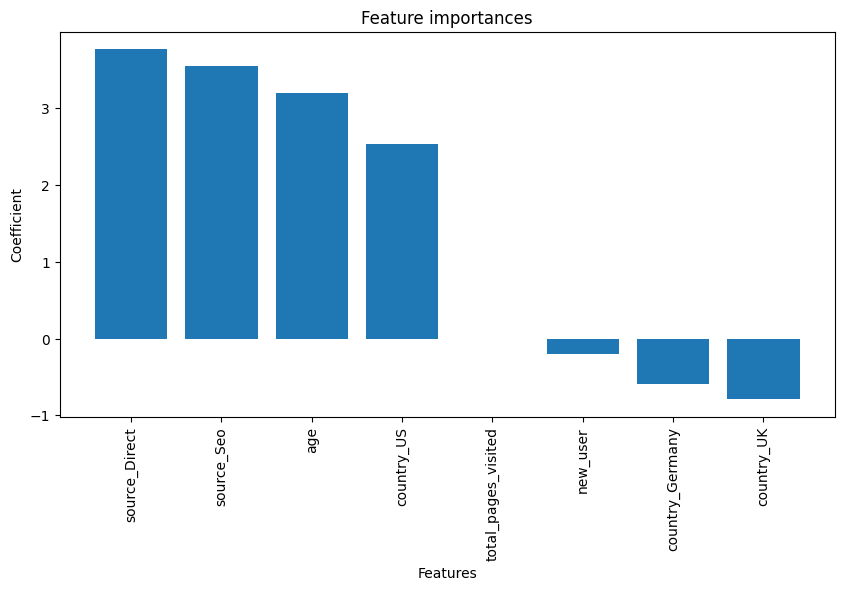

In [45]:
feature_names = list(trainer_baseline.preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features))
feature_names += numeric_features

# Extract coefficient values
coefs = trainer_baseline.best_model.coef_[0]
  
# Sort them and reverse (highest on top)
inds = np.argsort(coefs)[::-1]
sorted_coefs = coefs[inds]
sorted_features = np.array(feature_names)[inds]

# Take top 10
sorted_coefs_top10 = sorted_coefs[:10]
sorted_features_top10 = sorted_features[:10]

plt.figure(figsize=(10, 5))
plt.bar(sorted_features, sorted_coefs)
#plt.title('Top 10 feature importances')
plt.title('Feature importances')
plt.xlabel('Features')
plt.ylabel('Coefficient')
plt.xticks(rotation=90)
plt.show()

By analysing the feature importances, we notice that it is the sources that drive conversion rate followed by the age of the user. The source be attributed to the fact that when a user is looking for the site directly or is searching for it using a search engine, or by looking up a topic in the scope of the site, there's a higher chance that they'll subscribe. 

By focusing on these sources, and trying to increase exposure through targeted ads and sponsoring, it might lead to a higher conversion rate.

## Retraining the best model on the whole set:

Performing preprocessings on the set...
  country  age  new_user  source  total_pages_visited
0      UK   28         0     Seo                   16
1      UK   22         1  Direct                    5
2   China   32         1     Seo                    1
3      US   32         1     Ads                    6
4   China   25         0     Seo                    3
...Done.
[[-0.30636107 -1.47615748  3.32629502  0.          1.          0.
   0.          1.        ]
 [-1.04644166  0.6774345   0.03741548  0.          1.          0.
   1.          0.        ]
 [ 0.18702599  0.6774345  -1.15854072  0.          0.          0.
   0.          1.        ]
 [ 0.18702599  0.6774345   0.33640453  0.          0.          1.
   0.          0.        ]
 [-0.67640137 -1.47615748 -0.56056262  0.          0.          0.
   0.          1.        ]]



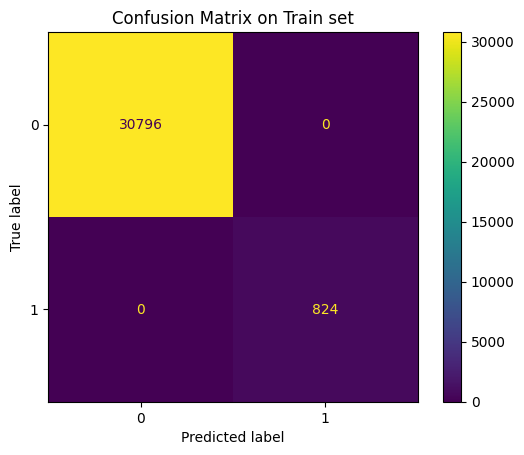

In [46]:
# Concatenate our train and test set to train your best classifier on all data with labels
X = np.append(X_train,X_test,axis=0)
Y = np.append(Y_train,Y_test)

# Warning : check consistency of features_list (must be the same than the features 
# used by your best classifier)
X_without_labels = data_test

# Preprocessings on X_without_labels
print("Performing preprocessings on the set...")
print(X_without_labels.head()) 
X_without_labels = preprocessor.transform(X_without_labels) # Don't fit again !! The test set is used for validating decisions
# we made based on the training set, therefore we can only apply transformations that were parametered using the training set.
# Otherwise this creates what is called a leak from the test set which will introduce a bias in all your results.
print('...Done.')
print(X_without_labels[0:5,:]) # MUST use this syntax because X_test is a numpy array and not a pandas DataFrame anymore
print()
# Visualize confusion matrices
_ , ax = plt.subplots() # Get subplot from matplotlib
ax.set(title="Confusion Matrix on Train set") # Set a title that we will add into ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(trainer_baseline.best_model, X_without_labels, trainer_baseline.best_model.predict(X_without_labels), ax=ax, ) # ConfusionMatrixDisplay from sklearn
plt.show()

# Make predictions and dump to file
data = {
    'converted': trainer_baseline.best_model.predict(X_without_labels)
}

Y_predictions = pd.DataFrame(columns=['converted'],data=data)
Y_predictions.to_csv('conversion_data_test_predictions_NIZAR-best_model.csv', index=False)